## Deep Fake Detection Challenge

### Data Processing

##### Imports

In [50]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
from typing import Tuple

##### Data Description

In [51]:
train_videoes = "data/train_sample_videos"
test_videos = "data/test_videos"

print(f"Train Videoes: {len(os.listdir(train_videoes))}\nTest Vidoes: {len(os.listdir(test_videos))}")

Train Videoes: 401
Test Vidoes: 400


In [52]:
meta_data = pd.read_json(train_videoes+"/metadata.json").T
meta_data.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [53]:
def visualize_real_vs_fake(class_count: list) -> None:
    plt.pie(class_count, labels=["Real Videos", "Deep Fake Videos"], autopct='%.2f%%',
       wedgeprops={'linewidth': 2.5, 'edgecolor': 'white'},
       textprops={'size': 'large', 'fontweight': 'bold'})
    plt.title("Proportion of Real vs Deep Fake videos in the training dataset.", fontdict={'fontweight': 'bold'})
    plt.legend([f"Real Videos Count: {class_count[0]}", f"Deep Fake Videos Count: {class_count[1]}"], bbox_to_anchor=(0.5, 0.05), bbox_transform=plt.gcf().transFigure, loc="lower center", prop={'weight':'bold'})
    plt.savefig("images/pie_chart_class_proportions.jpg")
    plt.show()

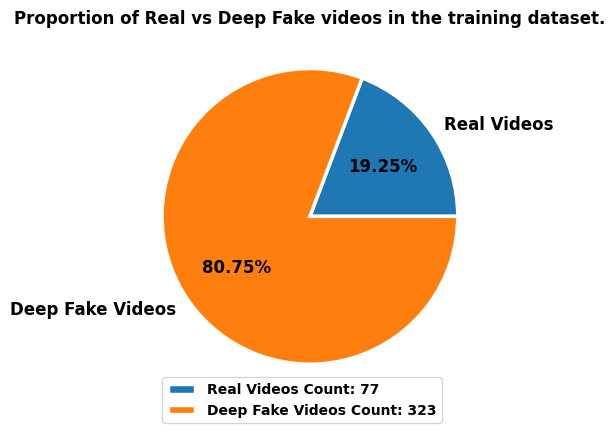

In [54]:
label_count_series = meta_data["label"].value_counts()
fake_count = label_count_series["FAKE"]
real_count = label_count_series["REAL"]

visualize_real_vs_fake([real_count, fake_count])

Quite skewed dataset. Might want to consider upsampling of real classes

In [55]:
from tqdm import tqdm

In [56]:
def get_frames_v1(paths: list, frames_each_video: int, video_amount: int) -> list:
    video_array = []
    frames_to_skip = 300/frames_each_video
    sumVertical = 0
    sumLandscape = 0
    for idx, path in enumerate(tqdm(paths)): # bedre me enumerate her?
        if idx == video_amount:
            break
        vc = cv2.VideoCapture(path)
        video = []
        i = 0
        while vc.isOpened():
            i += 1
            ret, frame = vc.read()
            if ret and frame is not None:
                if i % frames_to_skip != 0:
                    continue
                if frame.shape[0] == 1920:
                    frame = frame.transpose(1, 0, 2)
                    sumLandscape+=1
                else:
                    sumVertical+=1
                frame = cv2.resize(frame, (1280, 720))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                if frame is None:
                    continue
                video.append(frame)
            else:
                vc.release()
                break
        video_array.append(video)
    print("LandScape"+str(sumLandscape))
    print("Vertical"+str(sumVertical))
    return video_array

training_videos_sample = os.listdir(train_videoes)
sample_file_names = training_videos_sample.copy()
complete_paths = []
for i in range(len(training_videos_sample)):
    if training_videos_sample[i].endswith('mp4'):
        complete_paths.append(train_videoes+"/"+training_videos_sample[i])
video_array = get_frames_v1(paths=complete_paths, frames_each_video=2, video_amount=10)

  2%|▎         | 10/400 [00:16<10:42,  1.65s/it]

LandScape2
Vertical18


In [57]:
print(f"Amount of Videos: {len(video_array)}")
print(f"Frames for 6 video: {len(video_array[6])}")

Amount of Videos: 10
Frames for 6 video: 2


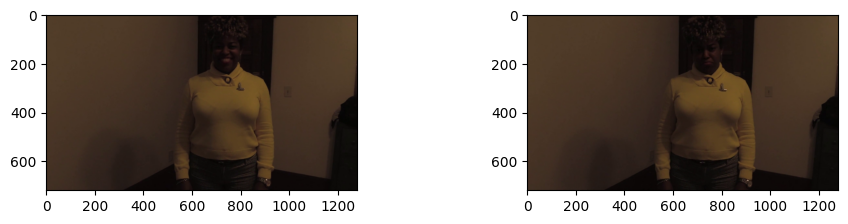

In [58]:
def plot_video(video: list, figsize: tuple, width: int, height: int) -> None:
    fig = plt.figure(figsize=figsize)
    for i in range(len(video[:(width*height)])):
        plt.subplot(width, height, i+1)
        plt.imshow(video[i])
    plt.show()

plot_video(video_array[6], (30,5), 2, 5)

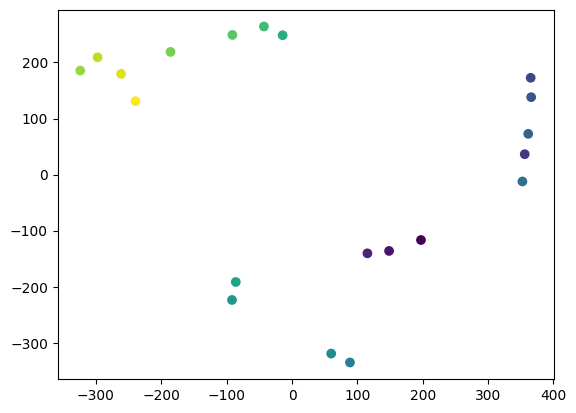

In [59]:
import matplotlib.pyplot as plt

# Assuming labels is a list of labels corresponding to each frame
plt.scatter(frames_tsne[:,0], frames_tsne[:,1], c=range(0,20))
plt.show()

In [60]:
from sklearn.manifold import TSNE
frames_list = video_array[0]
frames_array = np.array([frame.flatten() for frame in frames_list])
# Instantiate t-SNE object with desired parameters
print(2)
tsne = TSNE(n_components=2, perplexity=2, random_state=0)

# Fit t-SNE on the frames array
frames_tsne = tsne.fit_transform(frames_array)

2


ValueError: perplexity must be less than n_samples

In [ ]:
def format_frames(vid_arr):
    flatten_first_video_frame = vid_arr[0][0]
    flatten_first_video_frame = flatten_first_video_frame / 255
    return np.array([flatten_first_video_frame])
first_frame_formatted = format_frames(video_array)
first_frame_formatted.shape

(1, 720, 1280, 3)

### BUILD MODEL
- Add Layers
- Add Loss function, optimizers, and metrics
- Compile model and Fit

In [ ]:
model = keras.models.Sequential()
model.add(layers.Conv2D(filters=7, kernel_size=(3,3), padding="same", strides=2, activation="relu", input_shape=first_frame_formatted.shape[1:]))
model.add(layers.MaxPool2D(pool_size=(3,3)))
model.add(layers.Conv2D(filters=3, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(3,3)))
model.add(layers.Conv2D(filters=3, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(3,3)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(2))
#print(model.summary())

2023-04-11 15:02:26.430608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'first_frame_formatted' is not defined

In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
metrics=["accuracy"]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
batch_size = 32
epochs = 5

X = first_frame_formatted
Y =  np.array([[1, 0]])
print(Y.shape, X.shape)
res = model.fit(X, Y, verbose=2)
print(res.history["accuracy"])
his = model.predict(X)
print(his[0])

NameError: name 'first_frame_formatted' is not defined